In [1]:
import os, sys
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import warnings
sys.path.append('/tf/crypto_prediction_ml_dl/script')
from trino_operations import trino_operator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
import keras.backend as K
from keras.losses import mean_squared_error
from sklearn import metrics

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# run eagerly should be set to true. 
tf.config.run_functions_eagerly(True)

import copy


warnings.filterwarnings("ignore")
trino_ope = trino_operator.Operator()



def create_dataframe_from_query(query,column_list):
    res = trino_ope.run_query(query)

    indicators_query_result = {}
    for idx, row_data in enumerate(res,1):
        indicators_query_result[int(idx)] = row_data

    indicators_raw_df = pd.DataFrame.from_dict(
        indicators_query_result, orient="index", columns=column_list
    )

    return indicators_raw_df


def wmae_loss(y_true, y_pred):
    
    def step_function(data):
        return np.where(data >= 0, 1, 0)
    
    def calculate_gain(data):
        # Set the first gain value is 1 since there is no past data for the first data.
        gain_data = np.append(np.ndarray([1]), (data[1:] / data[:-1]) - 1.0)
        return gain_data
    
    l = 1.5
    
    diff = y_true[:,0] - y_pred[:,0]
    
    w_true = step_function(y_true[:, 1])
    w_pred = step_function(calculate_gain(y_pred[:, 1]))
    
    # Weighted mean absolute error
    threshold = w_true * diff
    wae = step_function(threshold) * ((l + abs(w_true - w_pred)) * abs(diff)) \
            + (1 - step_function(threshold)) * ((1/l) * abs(diff))
    wmae = sum(wae) / wae.shape[0]
    
    return wmae

def wmse_loss(y_true, y_pred):
    
    def step_function(data):
        return np.where(data >= 0, 1, 0)
    
    def calculate_gain(data):
        # Set the first gain value is 1 since there is no past data for the first data.
        gain_data = np.append(np.ndarray([1]), (data[1:] / data[:-1]) - 1.0)
        return gain_data
    
    l = 1.5
    
    diff = (y_true[:,0] - y_pred[:,0])**2
    
    w_true = step_function(y_true[:, 1])
    w_pred = step_function(calculate_gain(y_pred[:, 1]))
    
    # Weighted mean squared error
    threshold = w_true * diff
    wse = step_function(threshold) * ((l + abs(w_true - w_pred)) * abs(diff)) \
            + (1 - step_function(threshold)) * ((1/l) * abs(diff))
    wmse = sum(wse) / wse.shape[0]
    
    return wmse


def f1_metric(true, pred):

    def step_function(data):
        return np.where(data >= 0, 1, 0)
    
    def calculate_gain(data):
        # Set the first gain value is 1 since there is no past data for the first data.
        gain_data = np.append(np.ndarray([1]), (data[1:] / data[:-1]) - 1.0)
        return gain_data
    
    g_true = step_function(true[:, 1])
    g_pred = step_function(calculate_gain(pred[:, 0]))

    ground_positives = K.cast(K.sum(g_true, axis=0), "float") + K.epsilon()       # = TP + FN
    pred_positives = K.cast(K.sum(g_pred, axis=0), "float") + K.epsilon()         # = TP + FP
    true_positives = K.cast(K.sum(g_true * g_pred, axis=0), "float") + K.epsilon()  # = TP
    
    precision = true_positives / pred_positives 
    recall = true_positives / ground_positives
        #both = 1 if ground_positives == 0 or pred_positives == 0
        #shape (4,)

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
        #still with shape (4,)

    return f1

2023-11-09 09:54:51.592594: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-09 09:54:51.619690: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1


2023-11-09 09:54:52.551364: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-09 09:54:52.555222: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-09 09:54:52.555418: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
########################
# Create BTC_USDT featrue dataframe
########################
query = f"""
    with 
    ohlcv_minute_data as
    (
        select 
            open,
            high,
            low,
            close,
            amount as total_volume,
            quantity as total_quantity,
            tradeCount as total_trade_count,
            date_trunc('minute',ts_create_utc) as ts
        from 
            hive.crypto_raw.candles_minute 
        where 
            id = 'BTC_USDT'
    ),
    buy_tacker_market_data as
    (
        select
            date_trunc('minute',ts_create_utc) as ts,
            count(trade_id) as buy_trade_count,
            sum(amount) as sum_buy_taker_amount,
            sum(quantity)  as sum_buy_taker_quantity,
            avg(price) as avg_buy_trade_price
        from 
            hive.crypto_raw.market_trade
        where
            id = 'BTC_USDT'
            and takerSide = 'buy'
        group by
            1
    ), 
    sell_tacker_market_data as
    (
        select
            date_trunc('minute',ts_create_utc) as ts,
            count(trade_id) as sell_trade_count,
            sum(amount) as sum_sell_taker_amount,
            sum(quantity) as sum_sell_taker_quantity,
            avg(price) as avg_sell_trade_price
        from 
            hive.crypto_raw.market_trade
        where
            id = 'BTC_USDT'
            and takerSide = 'sell'
        group by
            1
    )
    select
        a.open as open,
        a.high as high,
        a.low as low,
        a.close as close,
        a.total_volume as total_volume,
        a.total_quantity as total_quantity,
        a.total_trade_count as total_trade_count,
        b.buy_trade_count as buy_trade_count,
        b.sum_buy_taker_amount as sum_buy_taker_amount,
        b.sum_buy_taker_quantity as sum_buy_taker_quantity,
        b.avg_buy_trade_price as avg_buy_trade_price,
        c.sell_trade_count as sell_trade_count,
        c.sum_sell_taker_amount as sum_sell_taker_amount,
        c.sum_sell_taker_quantity as sum_sell_taker_quantity,
        c.avg_sell_trade_price as avg_sell_trade_price,
        a.ts as ts
    from
        ohlcv_minute_data as a
    left join
        buy_tacker_market_data as b
    on a.ts = b.ts
    left join
        sell_tacker_market_data as c
    on 
        a.ts = c.ts
    where 
        b.buy_trade_count is not null
        and c.sell_trade_count is not null
    order by
        a.ts
"""

column_list = [
    'open',
    'high',
    'low',
    'close',
    'total_volume',
    'total_quantity',
    'total_trade_count',
    'buy_trade_count',
    'sum_buy_taker_amount',
    'sum_buy_taker_quantity',
    'avg_buy_trade_price',
    'sell_trade_count',
    'sum_sell_taker_amount',
    'sum_sell_taker_quantity',
    'avg_sell_trade_price',
    'ts'
]
btc_raw_df = create_dataframe_from_query(query,column_list)
btc_raw_df.tail()

,open,high,low,close,total_volume,total_quantity,total_trade_count,buy_trade_count,sum_buy_taker_amount,sum_buy_taker_quantity,avg_buy_trade_price,sell_trade_count,sum_sell_taker_amount,sum_sell_taker_quantity,avg_sell_trade_price,ts
91540,35845.15,35847.59,35835.98,35847.59,63339.93,1.767314,45,25,33520.5270,0.935306,35839.508,20,29819.4060,0.832008,35840.414,2023-11-09 00:56:00
91541,35847.39,35858.07,35847.39,35850.16,61762.42,1.722691,49,20,25174.3710,0.702152,35853.477,29,36588.0550,1.020539,35851.770,2023-11-09 00:57:00
91542,35850.73,35860.55,35844.02,35850.14,58213.78,1.623832,50,29,30833.6070,0.860088,35850.710,21,27380.1800,0.763744,35849.550,2023-11-09 00:58:00
91543,35839.71,35853.74,35826.33,35853.74,46752.40,1.304575,41,15,16282.1190,0.454348,35834.860,26,30470.2910,0.850227,35836.570,2023-11-09 00:59:00
91544,35853.95,35898.77,35847.46,35883.65,52992.11,1.477306,61,2,1941.9457,0.054168,35852.170,4,3904.3071,0.108901,35849.742,2023-11-09 01:00:00


In [5]:
p1_close_price = btc_raw_df["close"].shift(1)
btc_raw_df["p1_gain"] = btc_raw_df["close"] / p1_close_price - 1.0
btc_raw_df

,open,high,low,close,total_volume,total_quantity,total_trade_count,buy_trade_count,sum_buy_taker_amount,sum_buy_taker_quantity,avg_buy_trade_price,sell_trade_count,sum_sell_taker_amount,sum_sell_taker_quantity,avg_sell_trade_price,ts,p1_gain
1,25824.44,25831.18,25819.53,25825.24,95769.52,3.708438,72,41,53700.4500,2.079428,25825.186,31,42069.0740,1.629010,25824.785,2023-09-02 12:11:00,NaN
2,25825.69,25831.18,25824.56,25825.60,84266.64,3.262884,61,24,28694.2970,1.111076,25825.957,37,55572.3500,2.151808,25825.865,2023-09-02 12:12:00,1.393985e-05
3,25825.46,25826.37,25820.69,25825.53,75424.89,2.920544,56,29,36727.9600,1.422152,25825.590,27,38696.9340,1.498392,25825.506,2023-09-02 12:13:00,-2.710489e-06
4,25825.41,25830.08,25824.86,25826.63,64327.65,2.490819,51,24,27203.9940,1.053362,25826.016,27,37123.6600,1.437457,25825.879,2023-09-02 12:14:00,4.259351e-05
5,25826.25,25831.17,25825.55,25826.26,66004.63,2.555701,44,24,33439.0300,1.294760,25826.838,20,32565.6050,1.260941,25826.398,2023-09-02 12:15:00,-1.432630e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91540,35845.15,35847.59,35835.98,35847.59,63339.93,1.767314,45,25,33520.5270,0.935306,35839.508,20,29819.4060,0.832008,35840.414,2023-11-09 00:56:00,5.216801e-05
91541,35847.39,35858.07,35847.39,35850.16,61762.42,1.722691,49,20,25174.3710,0.702152,35853.477,29,36588.0550,1.020539,35851.770,2023-11-09 00:57:00,7.169241e-05
91542,35850.73,35860.55,35844.02,35850.14,58213.78,1.623832,50,29,30833.6070,0.860088,35850.710,21,27380.1800,0.763744,35849.550,2023-11-09 00:58:00,-5.578776e-07
91543,35839.71,35853.74,35826.33,35853.74,46752.40,1.304575,41,15,16282.1190,0.454348,35834.860,26,30470.2910,0.850227,35836.570,2023-11-09 00:59:00,1.004180e-04


In [6]:
####################################
# Create Dataset with target value
####################################
predicting_points = 1
btc_df_with_target = btc_raw_df
target_column_to_predict = 'close'
f1_close = btc_raw_df[target_column_to_predict].shift(-predicting_points)
btc_df_with_target['f1_close'] = f1_close
btc_df_with_target.tail(10)

,open,high,low,close,total_volume,total_quantity,total_trade_count,buy_trade_count,sum_buy_taker_amount,sum_buy_taker_quantity,avg_buy_trade_price,sell_trade_count,sum_sell_taker_amount,sum_sell_taker_quantity,avg_sell_trade_price,ts,p1_gain,f1_close
91535,35846.26,35852.51,35819.28,35836.49,77465.01,2.161351,60,28,32607.8100,0.909775,35840.984,32,44857.2070,1.251576,35840.812,2023-11-09 00:51:00,-3.740596e-04,35820.71
91536,35836.93,35836.96,35816.91,35820.71,76445.98,2.133855,56,27,35590.9450,0.993480,35825.340,29,40855.0430,1.140375,35827.700,2023-11-09 00:52:00,-4.403333e-04,35838.60
91537,35820.05,35848.49,35816.28,35838.60,60917.16,1.699934,50,25,31327.4400,0.874193,35835.120,25,29589.7230,0.825741,35833.504,2023-11-09 00:53:00,4.994318e-04,35844.34
91538,35838.13,35851.58,35827.20,35844.34,59439.53,1.658573,50,25,27802.3050,0.775739,35839.945,25,31637.2290,0.882834,35836.438,2023-11-09 00:54:00,1.601625e-04,35845.72
91539,35847.52,35860.82,35837.55,35845.72,59911.58,1.671449,48,27,32407.4700,0.904137,35844.453,21,27504.1170,0.767312,35844.820,2023-11-09 00:55:00,3.849980e-05,35847.59
91540,35845.15,35847.59,35835.98,35847.59,63339.93,1.767314,45,25,33520.5270,0.935306,35839.508,20,29819.4060,0.832008,35840.414,2023-11-09 00:56:00,5.216801e-05,35850.16
91541,35847.39,35858.07,35847.39,35850.16,61762.42,1.722691,49,20,25174.3710,0.702152,35853.477,29,36588.0550,1.020539,35851.770,2023-11-09 00:57:00,7.169241e-05,35850.14
91542,35850.73,35860.55,35844.02,35850.14,58213.78,1.623832,50,29,30833.6070,0.860088,35850.710,21,27380.1800,0.763744,35849.550,2023-11-09 00:58:00,-5.578776e-07,35853.74
91543,35839.71,35853.74,35826.33,35853.74,46752.40,1.304575,41,15,16282.1190,0.454348,35834.860,26,30470.2910,0.850227,35836.570,2023-11-09 00:59:00,1.004180e-04,35883.65
91544,35853.95,35898.77,35847.46,35883.65,52992.11,1.477306,61,2,1941.9457,0.054168,35852.170,4,3904.3071,0.108901,35849.742,2023-11-09 01:00:00,8.342226e-04,NaN


In [7]:
# Check if the target value is defined as the future close value.
btc_df_with_target[['close','p1_gain','f1_close']].tail(10)

,close,p1_gain,f1_close
91535,35836.49,-3.740596e-04,35820.71
91536,35820.71,-4.403333e-04,35838.60
91537,35838.60,4.994318e-04,35844.34
91538,35844.34,1.601625e-04,35845.72
91539,35845.72,3.849980e-05,35847.59
91540,35847.59,5.216801e-05,35850.16
91541,35850.16,7.169241e-05,35850.14
91542,35850.14,-5.578776e-07,35853.74
91543,35853.74,1.004180e-04,35883.65
91544,35883.65,8.342226e-04,NaN


In [8]:
btc_df_with_target.describe()

,open,high,low,close,total_volume,total_quantity,total_trade_count,buy_trade_count,sum_buy_taker_amount,sum_buy_taker_quantity,avg_buy_trade_price,sell_trade_count,sum_sell_taker_amount,sum_sell_taker_quantity,avg_sell_trade_price,ts,p1_gain,f1_close
count,91544.000000,91544.000000,91544.000000,91544.000000,91544.000000,91544.000000,91544.000000,91544.000000,91544.000000,91544.000000,91544.000000,91544.000000,91544.000000,91544.000000,91544.000000,91544,9.154300e+04,91543.000000
mean,28855.073347,28862.313486,28848.007599,28855.598107,32677.627218,1.121739,28.426909,14.065225,16486.836620,0.565268,28855.833776,14.358363,16187.873402,0.556386,28854.924943,2023-10-06 10:53:20.698243072,3.726705e-06,28855.631210
min,24947.390000,25004.330000,24923.650000,24947.410000,5.400000,0.000173,2.000000,1.000000,0.026938,0.000001,24962.285000,1.000000,0.027108,0.000001,24974.842000,2023-09-02 12:11:00,-1.500610e-02,24947.410000
25%,26530.357500,26534.415000,26526.247500,26530.560000,16064.055000,0.571851,15.000000,7.000000,7502.498875,0.264887,26530.700500,7.000000,7492.979500,0.264732,26530.328500,2023-09-20 05:02:45,-1.691664e-04,26530.560000
50%,27257.920000,27265.010000,27250.040000,27259.380000,25093.295000,0.877749,23.000000,11.000000,12582.068000,0.442316,27258.747000,11.000000,12618.743500,0.443584,27257.697500,2023-10-06 11:20:30,7.368407e-07,27259.470000
75%,30127.250000,30138.167500,30118.202500,30128.360000,42031.000000,1.481024,36.000000,18.000000,21296.579500,0.744345,30130.533500,18.000000,20993.763500,0.729654,30127.332500,2023-10-23 00:01:15,1.780198e-04,30128.380000
max,35982.480000,36091.740000,35957.760000,35990.000000,601811.300000,22.802782,887.000000,613.000000,549705.060000,16.123856,36008.390000,376.000000,411043.200000,15.579352,36007.188000,2023-11-09 01:00:00,2.450037e-02,35990.000000
std,3338.115857,3340.784815,3335.577715,3338.292445,26539.850568,0.864180,21.849921,12.141089,14616.612809,0.476435,3338.448213,11.850719,13878.847378,0.458079,3338.001223,NaN,5.169909e-04,3338.295654


In [9]:
# NaN value might be included in the dataset.
# Count the number of NaN for each column.
labels = []
values = []
print('# of records:',btc_df_with_target.shape[0])
print('<column name>: # of NaN records in the column')
for col in btc_df_with_target.columns:
    labels.append(col)
    values.append(btc_df_with_target[col].isnull().sum())
    print("{}: {}".format(col, values[-1]))

# of records: 91544
<column name>: # of NaN records in the column
open: 0
high: 0
low: 0
close: 0
total_volume: 0
total_quantity: 0
total_trade_count: 0
buy_trade_count: 0
sum_buy_taker_amount: 0
sum_buy_taker_quantity: 0
avg_buy_trade_price: 0
sell_trade_count: 0
sum_sell_taker_amount: 0
sum_sell_taker_quantity: 0
avg_sell_trade_price: 0
ts: 0
p1_gain: 1
f1_close: 1


In [10]:
btc_df_with_target = btc_df_with_target.dropna()

# NaN value might be included in the dataset.
# Count the number of NaN for each column.
labels = []
values = []
print('# of records:',btc_df_with_target.shape[0])
print('<column name>: # of NaN records in the column')
for col in btc_df_with_target.columns:
    labels.append(col)
    values.append(btc_df_with_target[col].isnull().sum())
    print("{}: {}".format(col, values[-1]))

# of records: 91542
<column name>: # of NaN records in the column
open: 0
high: 0
low: 0
close: 0
total_volume: 0
total_quantity: 0
total_trade_count: 0
buy_trade_count: 0
sum_buy_taker_amount: 0
sum_buy_taker_quantity: 0
avg_buy_trade_price: 0
sell_trade_count: 0
sum_sell_taker_amount: 0
sum_sell_taker_quantity: 0
avg_sell_trade_price: 0
ts: 0
p1_gain: 0
f1_close: 0


In [11]:
# Drop timestamp column
btc_ts = btc_df_with_target['ts']
dataset_raw_df = btc_df_with_target.drop(['ts'], axis=1)
dataset_raw_df.tail()

,open,high,low,close,total_volume,total_quantity,total_trade_count,buy_trade_count,sum_buy_taker_amount,sum_buy_taker_quantity,avg_buy_trade_price,sell_trade_count,sum_sell_taker_amount,sum_sell_taker_quantity,avg_sell_trade_price,p1_gain,f1_close
91539,35847.52,35860.82,35837.55,35845.72,59911.58,1.671449,48,27,32407.470,0.904137,35844.453,21,27504.117,0.767312,35844.820,3.849980e-05,35847.59
91540,35845.15,35847.59,35835.98,35847.59,63339.93,1.767314,45,25,33520.527,0.935306,35839.508,20,29819.406,0.832008,35840.414,5.216801e-05,35850.16
91541,35847.39,35858.07,35847.39,35850.16,61762.42,1.722691,49,20,25174.371,0.702152,35853.477,29,36588.055,1.020539,35851.770,7.169241e-05,35850.14
91542,35850.73,35860.55,35844.02,35850.14,58213.78,1.623832,50,29,30833.607,0.860088,35850.710,21,27380.180,0.763744,35849.550,-5.578776e-07,35853.74
91543,35839.71,35853.74,35826.33,35853.74,46752.40,1.304575,41,15,16282.119,0.454348,35834.860,26,30470.291,0.850227,35836.570,1.004180e-04,35883.65


In [12]:
# Scale data (MinMaxSclaer, Normalization)
from sklearn.preprocessing import MinMaxScaler
sc_features = MinMaxScaler(feature_range = (0,1))
feature_columns = [
    'open',
    'high',
    'low',
    'close',
    'total_volume',
    'total_quantity',
    'total_trade_count',
    'buy_trade_count',
    'sum_buy_taker_amount',
    'sum_buy_taker_quantity',
    'avg_buy_trade_price',
    'sell_trade_count',
    'sum_sell_taker_amount',
    'sum_sell_taker_quantity',
    'avg_sell_trade_price'
]
feature_columns = [
    'open',
    'high',
    'low',
    'close'
]
dataset_feature_scaled = sc_features.fit_transform(dataset_raw_df[feature_columns])
print(dataset_feature_scaled.shape)
dataset_feature_scaled

(91542, 4)


array([[0.07959156, 0.07457558, 0.08164773, 0.07952754],
       [0.07957071, 0.07414175, 0.081297  , 0.0795212 ],
       [0.07956618, 0.07447637, 0.08167492, 0.07962081],
       ...,
       [0.98775814, 0.97892474, 0.98999738, 0.9873363 ],
       [0.98806081, 0.97914842, 0.98969196, 0.98733449],
       [0.98706218, 0.97853421, 0.98808875, 0.9876605 ]])

In [13]:
dataset_feature_scaled = sc_features.fit_transform(dataset_raw_df[feature_columns])
print(dataset_feature_scaled.shape)
dataset_feature_scaled

(91542, 4)


array([[0.07959156, 0.07457558, 0.08164773, 0.07952754],
       [0.07957071, 0.07414175, 0.081297  , 0.0795212 ],
       [0.07956618, 0.07447637, 0.08167492, 0.07962081],
       ...,
       [0.98775814, 0.97892474, 0.98999738, 0.9873363 ],
       [0.98806081, 0.97914842, 0.98969196, 0.98733449],
       [0.98706218, 0.97853421, 0.98808875, 0.9876605 ]])

In [14]:
sc_target = MinMaxScaler(feature_range = (0,1))
target_colums = ['f1_close','p1_gain']
dataset_target_scaled = sc_target.fit_transform(dataset_raw_df[target_colums])
print(dataset_target_scaled.shape)
dataset_target_scaled

(91542, 2)


array([[0.0795212 , 0.38019183],
       [0.07962081, 0.37977037],
       [0.07958731, 0.38091712],
       ...,
       [0.98733449, 0.38165368],
       [0.9876605 , 0.37982486],
       [0.99036911, 0.3823808 ]])

In [15]:
# Add past close price data to the dataset.
train_size = 0.8
test_size = 0.2

train_index_to = int(len(dataset_feature_scaled)*train_size)
test_index_to = len(dataset_feature_scaled)

past_N = 10
X_train = []
y_train = []
for i in range(past_N,train_index_to):
    X_train.append(np.concatenate((dataset_feature_scaled[i],dataset_feature_scaled[i-past_N+1:i, 3:].flatten()), axis = 0))
    y_train.append(dataset_target_scaled[i])
X_train,y_train = np.array(X_train),np.array(y_train)
print('X_train shape',X_train.shape)

X_test = []
y_test = []
for i in range(train_index_to,test_index_to):
    X_test.append(np.concatenate((dataset_feature_scaled[i], dataset_feature_scaled[i-past_N+1:i, 3:].flatten()), axis = 0))
    y_test.append(dataset_target_scaled[i])
X_test,y_test = np.array(X_test),np.array(y_test)
print('X_test shape',X_test.shape)

X_train shape (73223, 13)
X_test shape (18309, 13)


In [16]:
# Create a Sequential model
regressor = Sequential()

regressor.add(LSTM(units = 1024,return_sequences = True,input_shape = (X_train.shape[1],1)))
regressor.add(Dropout(0.3))
regressor.add(LSTM(units = 1024,return_sequences = False))
regressor.add(Dense(units = 2))

regressor.compile(optimizer = 'Adagrad',loss = wmse_loss, metrics = ['mse', f1_metric], run_eagerly=True)
regressor.summary()

# second fit
callback = EarlyStopping(monitor='val_loss', patience=5)
history = regressor.fit(X_train, y_train, 
                        epochs = 100,
                        batch_size = 64,
                        validation_split=0.3, 
                        shuffle=False, 
                        callbacks=[callback])

2023-11-09 09:55:27.283550: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-09 09:55:27.283807: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-09 09:55:27.283984: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 13, 1024)          4202496   
                                                                 
 dropout (Dropout)           (None, 13, 1024)          0         
                                                                 
 lstm_1 (LSTM)               (None, 1024)              8392704   
                                                                 
 dense (Dense)               (None, 2)                 2050      
                                                                 
Total params: 12597250 (48.05 MB)
Trainable params: 12597250 (48.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100


2023-11-09 09:55:29.646227: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-09 09:55:29.727134: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


801/801 [==============================] - 30s 37ms/step - loss: 0.0013 - mse: 0.0692 - f1_metric: 0.6740 - val_loss: 0.1153 - val_mse: 0.0940 - val_f1_metric: 0.6819
Epoch 2/100
801/801 [==============================] - 29s 37ms/step - loss: 0.0021 - mse: 0.0694 - f1_metric: 0.6743 - val_loss: 0.1096 - val_mse: 0.0924 - val_f1_metric: 0.6816
Epoch 3/100
801/801 [==============================] - 29s 37ms/step - loss: 0.0023 - mse: 0.0694 - f1_metric: 0.6735 - val_loss: 0.1032 - val_mse: 0.0907 - val_f1_metric: 0.6820
Epoch 4/100
801/801 [==============================] - 30s 37ms/step - loss: 0.0024 - mse: 0.0694 - f1_metric: 0.6745 - val_loss: 0.0968 - val_mse: 0.0904 - val_f1_metric: 0.6835
Epoch 5/100
801/801 [==============================] - 30s 37ms/step - loss: 0.0023 - mse: 0.0694 - f1_metric: 0.6735 - val_loss: 0.0907 - val_mse: 0.0878 - val_f1_metric: 0.6817
Epoch 6/100
801/801 [==============================] - 29s 36ms/step - loss: 0.0023 - mse: 0.0694 - f1_metric: 0.6735

Epoch 46/100
801/801 [==============================] - 30s 38ms/step - loss: 3.1899e-04 - mse: 0.0694 - f1_metric: 0.6720 - val_loss: 7.0959e-04 - val_mse: 0.0630 - val_f1_metric: 0.6825
Epoch 47/100
801/801 [==============================] - 30s 38ms/step - loss: 1.8329e-04 - mse: 0.0694 - f1_metric: 0.6724 - val_loss: 0.0053 - val_mse: 0.0690 - val_f1_metric: 0.6824
Epoch 48/100
801/801 [==============================] - 30s 38ms/step - loss: 9.2785e-05 - mse: 0.0693 - f1_metric: 0.6733 - val_loss: 8.7085e-04 - val_mse: 0.0642 - val_f1_metric: 0.6826
Epoch 49/100
801/801 [==============================] - 31s 38ms/step - loss: 3.2138e-05 - mse: 0.0693 - f1_metric: 0.6727 - val_loss: 6.1342e-04 - val_mse: 0.0631 - val_f1_metric: 0.6819
Epoch 50/100
801/801 [==============================] - 31s 38ms/step - loss: 1.7633e-04 - mse: 0.0694 - f1_metric: 0.6727 - val_loss: 0.0043 - val_mse: 0.0653 - val_f1_metric: 0.6825
Epoch 51/100
801/801 [==============================] - 30s 37ms/ste

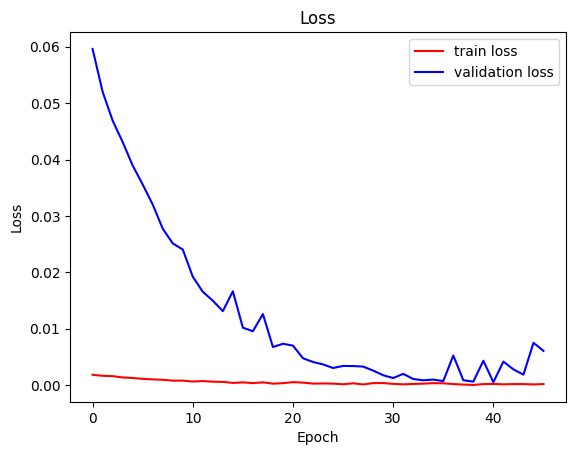

In [17]:
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']
plt.plot(loss_history[10:], color = 'red', label = 'train loss')
plt.plot(val_loss_history[10:], color = 'blue', label = 'validation loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

573/573 [==============================] - 2s 4ms/step
predicted_price shape: (18308, 2)
real_price shape: (18308, 2)


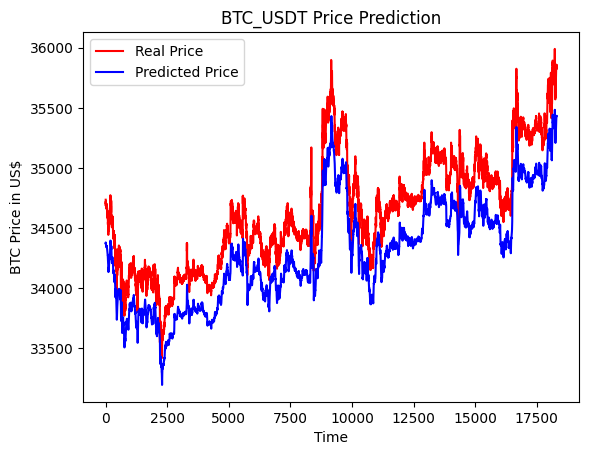

In [18]:
# Predict test data and revert the price to the original scale
predicted_price = regressor.predict(X_test)
predicted_price = sc_target.inverse_transform(predicted_price)[:-predicting_points]
print('predicted_price shape:',predicted_price.shape)
# predicted_price

real_price = sc_target.inverse_transform(y_test)[:-predicting_points]
print('real_price shape:',real_price.shape)
# real_price

plt.plot(real_price[:,0], color = 'red', label = 'Real Price')
plt.plot(predicted_price[:,0], color = 'blue', label = 'Predicted Price')
plt.title('BTC_USDT Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Price in US$')
plt.legend()
plt.show()

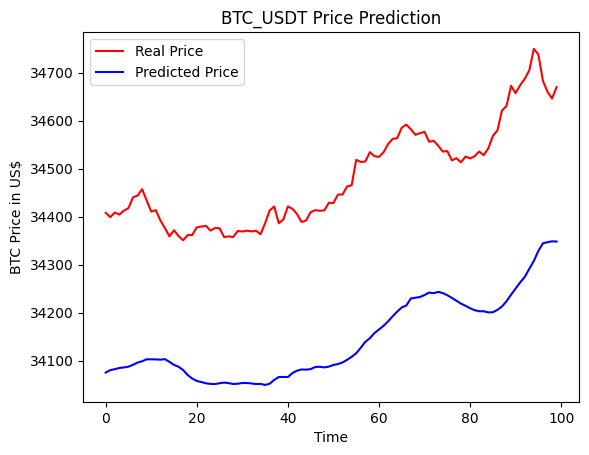

In [19]:
plt.plot(real_price[10900:11000, 0], color = 'red', label = 'Real Price')
plt.plot(predicted_price[10900:11000, 0], color = 'blue', label = 'Predicted Price')
plt.title('BTC_USDT Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Price in US$')
plt.legend()
plt.show()

In [ ]:
test_wmse = wmse_loss(real_price, predicted_price)
test_f1 = f1_metric(real_price, predicted_price)

print("test_wmse:",test_wmse)
print("test_f1:",test_f1)